In [1]:
from aquacrop.classes import *
from aquacrop.core import *
 
# import gym
# from gym import spaces
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from aquacrop.lars import *
# import math

In [2]:
from aquacropgym.utils import calc_eto_faopm

In [3]:
class FixedThresholdAgent():
    def __init__(self,smts):
        self.smts=smts # gievn as fraction

    
    def compute_action(self,obs):
        "default observation set"

        dep = obs[2]

        gs1h = obs[-4:]
        gs=np.argmax(gs1h)

        if gs<0 or gs>3:
            action=0
        else:
            if 1-dep< (self.smts[gs]):
                action=1
            else:
                action=0
    

        return action

In [4]:
class FixedThresholdAgent():
    def __init__(self,smts):
        self.smts=smts # gievn as fraction

    
    def compute_action(self,obs):
        "default observation set"

        return (self.smts*2)-1

In [5]:
from aquacropgym.utils import calc_eto_faopm
from aquacropgym.envs import CropEnv, nebraska_maize_config, cordoba_cotton_config,california_tomato_config
from aquacropgym.utils import evaluate_agent,evaluate_agent_single_year
from aquacropgym.utils import calc_eto_faopm

In [6]:
gendf=calc_eto_faopm('data/CPWG.dat',1995,40.4,1072,True,["simyear","jday","minTemp","maxTemp","precip","rad"])


In [7]:
test_env_config=nebraska_maize_config.copy()

test_env_config['gendf']=gendf
test_env_config['evaluation_run']=True
test_env_config['normalize_obs']=False
# test_env_config['include_rain']=False
test_env_config['action_set']='smt4'
test_env_config['observation_set']='default'
test_env_config['days_to_irr']=1



In [8]:
agent = FixedThresholdAgent(np.array([0.69892958, 0.56825608, 0.35286359, 0.11124398]))

In [9]:
evaluate_agent(agent,CropEnv,test_env_config)

(513.0584847087756, 521.3771423907657)

In [10]:
import ray
ray.shutdown()
ray.init(num_cpus=8,num_gpus=0)

{'node_ip_address': '192.168.93.125',
 'raylet_ip_address': '192.168.93.125',
 'redis_address': '192.168.93.125:6379',
 'object_store_address': '/tmp/ray/session_2022-03-14_09-33-15_867592_6128/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-03-14_09-33-15_867592_6128/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-03-14_09-33-15_867592_6128',
 'metrics_export_port': 63229,
 'node_id': 'd5d4b0cea51265c7d673ad882236cfb7d70fb479b22aca72562015c3'}

In [11]:
import gym
import numpy as np
import os

import ray._private.utils

from ray.rllib.models.preprocessors import get_preprocessor
from ray.rllib.evaluation.sample_batch_builder import SampleBatchBuilder
from ray.rllib.offline.json_writer import JsonWriter

batch_builder = SampleBatchBuilder()  # or MultiAgentSampleBatchBuilder
writer = JsonWriter(
    os.path.join('cloning_data', "smt4"))


for i in range(70):
    envconfig=test_env_config.copy()
    envconfig['year1']=i+1
    envconfig['year2']=i+1
    env = CropEnv(envconfig)


    obs = env.reset()
    prev_action = np.zeros_like(env.action_space.sample())
    prev_reward = 0
    done = False
    t = 0
    while not done:
        action = agent.compute_action(obs)

        new_obs, rew, done, info = env.step(action)
        batch_builder.add_values(
            t=t,
            eps_id=i,
            agent_index=0,
            obs=(obs-env.mean)/env.std,
            actions=action,
            action_prob=1.0,  # put the true action probability here
            action_logp=0.0,
            rewards=rew/1000,
            prev_actions=prev_action,
            prev_rewards=prev_reward,
            dones=done,
            infos=info,
            new_obs=(new_obs-env.mean)/env.std
            )
        obs = new_obs
        prev_action = action
        prev_reward = rew
        t += 1
    writer.write(batch_builder.build_and_reset())

2022-03-14 09:33:20,291	WARNING deprecation.py:45 -- DeprecationWarning: `SampleBatchBuilder` has been deprecated. Use `a child class of `SampleCollector`` instead. This will raise an error in the future!
2022-03-14 09:33:20,402	INFO json_writer.py:97 -- Writing to new output file <_io.TextIOWrapper name='/home/mbyx3tk2/p2dev/feb25/aquacrop-gym/cloning_data/smt4/output-2022-03-14_09-33-20_worker-0_0.json' mode='w' encoding='UTF-8'>


In [12]:
import ray
ray.shutdown()
ray.init(num_cpus=8,num_gpus=0)

{'node_ip_address': '192.168.93.125',
 'raylet_ip_address': '192.168.93.125',
 'redis_address': '192.168.93.125:6379',
 'object_store_address': '/tmp/ray/session_2022-03-14_09-33-27_630832_6128/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-03-14_09-33-27_630832_6128/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-03-14_09-33-27_630832_6128',
 'metrics_export_port': 58052,
 'node_id': 'b756a8db2161e65a172334ca228fbcc17da437cd7fae0d6c4e1a0a68'}

In [13]:
test_env_config=nebraska_maize_config.copy()

test_env_config['gendf']=gendf
test_env_config['evaluation_run']=False
test_env_config['normalize_obs']=True
# test_env_config['include_rain']=False
test_env_config['action_set']='smt4'
test_env_config['observation_set']='default'
test_env_config['days_to_irr']=1



In [14]:
from ray.rllib.agents.marwil.marwil import MARWILTrainer,DEFAULT_CONFIG

config = DEFAULT_CONFIG.copy()

config['env'] = CropEnv
config['num_workers'] = 8
config['num_gpus'] = 0
config['beta'] = 0.

config['model']['fcnet_hiddens'] = [128]*4
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['framework'] = 'torch'
config['gamma'] = 0.99999999
config['env_config']=test_env_config
# config['input']={
#     './cloning_data/smt4/':0.5,
#     'sampler':0.5,

# }
config['input']='./cloning_data/smt4/'
config['model']['vf_share_layers'] = False

# config['input_evaluation'] = []



In [15]:
bcagent = MARWILTrainer(config)

2022-03-14 09:33:53,954	INFO trainer.py:743 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-03-14 09:33:56,481	WARNING deprecation.py:45 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!
2022-03-14 09:33:56,484	WARNING json_reader.py:63 -- Treating input directory as glob patterns: ['/home/mbyx3tk2/p2dev/feb25/aquacrop-gym/cloning_data/smt4/*.json', '/home/mbyx3tk2/p2dev/feb25/aquacrop-gym/cloning_data/smt4/*.zip']
2022-03-14 09:33:56,488	WARNING util.py:57 -- Install gputil for GPU system monitoring.
(RolloutWorker pid=6865) 2022-03-14 09:33:56,451	WARNING json_reader.py:63 -- Treating input directory as glob patterns: ['/home/mbyx3tk2/p2dev/feb25/aquacrop-gym/cloning_data/smt4/*.json', '/home/mbyx3tk2/p2dev/feb25/aquacrop-gym/cloning_data/smt4/*.zip']
(RolloutWorker pid=6866) 2022-03-14 09:33:56

In [16]:
import copy

2022-03-04 15:53:14,972	WARNING deprecation.py:45 -- DeprecationWarning: `compute_action` has been deprecated. Use `compute_single_action` instead. This will raise an error in the future!


Train:142.04
Test:150.767
Train:142.241
Test:153.59
Train:144.132
Test:144.627
/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000010/checkpoint-10


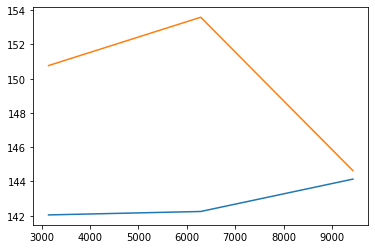

Train:145.865
Test:153.554
Train:148.017
Test:147.821
Train:148.466
Test:157.618
/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000020/checkpoint-20


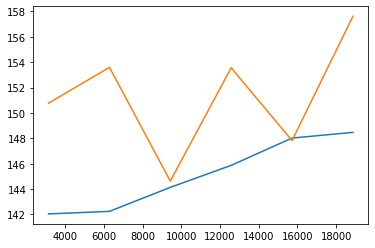

Train:164.926
Test:164.651
Train:149.414
Test:163.587
Train:153.873
Test:159.705
/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000030/checkpoint-30


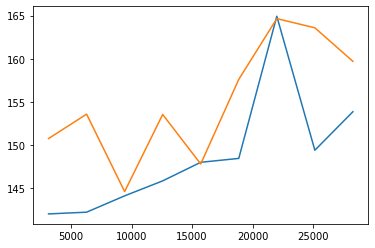

Train:168.551
Test:157.145
Train:165.894
Test:179.432
Train:169.676
Test:171.936
Train:174.022
Test:165.193
/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000040/checkpoint-40


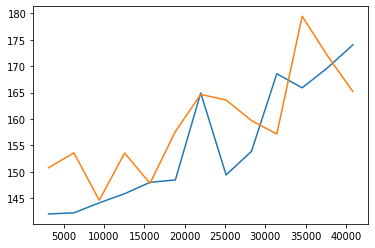

Train:175.911
Test:185.485
Train:184.057
Test:196.403
Train:202.823
Test:202.872
/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000050/checkpoint-50


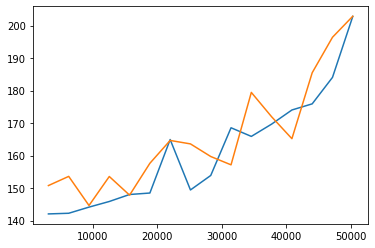

Train:192.428
Test:210.186
Train:227.296
Test:221.952
Train:216.388
Test:230.831
/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000060/checkpoint-60


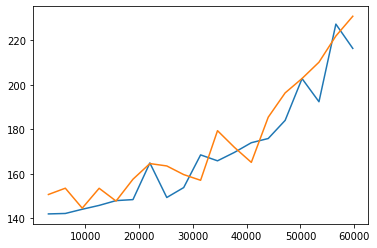

Train:237.974
Test:243.653
Train:254.846
Test:239.091
Train:265.861
Test:271.951
Train:283.522
Test:289.033
/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000070/checkpoint-70


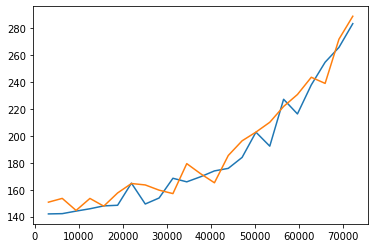

Train:293.951
Test:312.972
Train:309.924
Test:334.607
Train:342.992
Test:342.361
/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000080/checkpoint-80


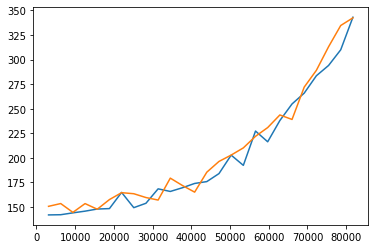

Train:349.082
Test:362.532
Train:378.657
Test:382.293
Train:394.736
Test:406.318
/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000090/checkpoint-90


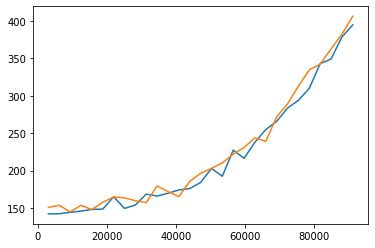

Train:409.369
Test:424.7
Train:423.959
Test:432.486
Train:434.426
Test:443.103
Train:441.319
Test:448.884
/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000100/checkpoint-100


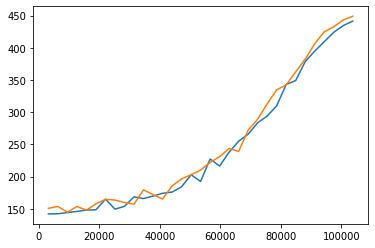

Train:448.546
Test:458.352
Train:454.798
Test:465.635
Train:459.713
Test:479.076
/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000110/checkpoint-110


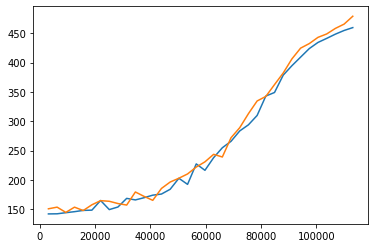

Train:470.349
Test:490.846
Train:478.76
Test:483.369
Train:480.129
Test:494.708
/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000120/checkpoint-120


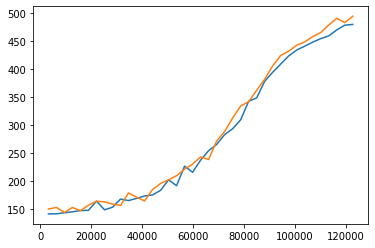

Train:486.619
Test:490.463
Train:488.119
Test:498.18
Train:491.723
Test:499.406
Train:497.708
Test:502.336
/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000130/checkpoint-130


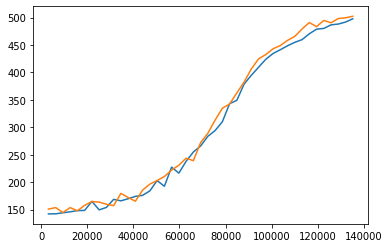

Train:500.911
Test:509.233


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:496.956
Test:509.627


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_WIS += p[t] / w_t * rewards[t] * self.gamma**t
(RolloutWorker pid=43234) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43234)   p.a

Train:503.606
Test:508.604


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000140/checkpoint-140


(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_WIS += p[t] / w_t * rewards[t] * self.gamma**t
(RolloutWorker pid=43234) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: Runtim

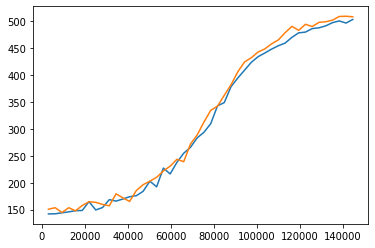

(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:501.992
Test:508.82


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:504.587
Test:514.899


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:506.468
Test:513.291


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000150/checkpoint-150


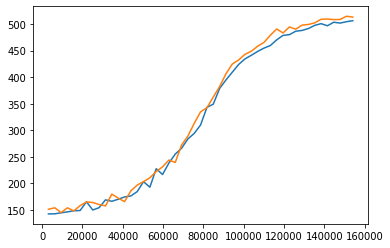

Train:504.74
Test:516.596


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:507.136
Test:513.166


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:508.666
Test:513.348


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:508.72
Test:517.462


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000160/checkpoint-160


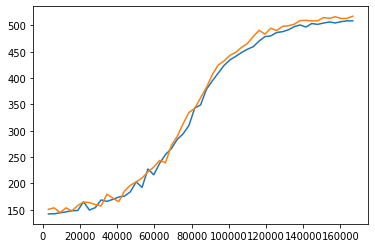

(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:508.595
Test:516.859


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:509.83
Test:519.823


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:511.797
Test:520.005


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000170/checkpoint-170


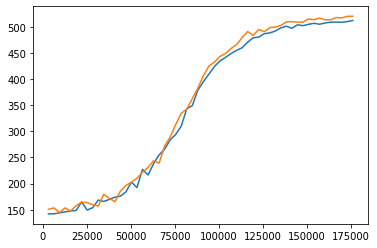

(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:511.898
Test:516.908


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:512.129
Test:518.852


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:512.598
Test:516.731


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000180/checkpoint-180


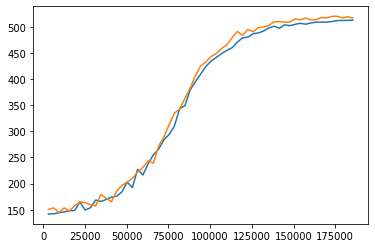

Train:511.446
Test:519.328


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:512.699
Test:518.171


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:511.635
Test:520.27


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:510.528
Test:520.38


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000190/checkpoint-190


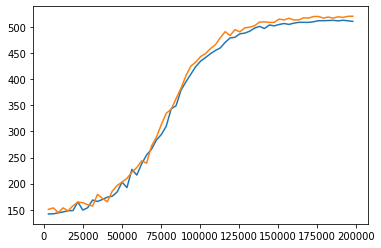

(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:512.437
Test:519.719


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:512.685
Test:519.572


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:511.158
Test:521.731


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000200/checkpoint-200


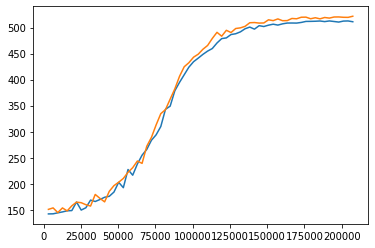

(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:512.047
Test:521.513


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:510.722
Test:519.444


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:511.929
Test:518.001


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000210/checkpoint-210


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

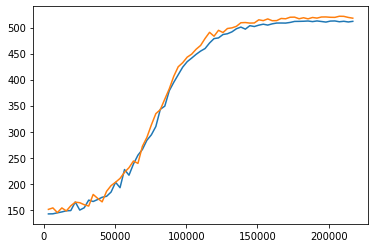

Train:515.405
Test:522.495


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:512.845
Test:521.233


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

Train:515.153
Test:519.889


(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:26: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/is_estimator.py:32: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_step_IS += p[t] * rewards[t] * self.gamma**t
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:32: RuntimeWarning: overflow encountered in double_scalars
(RolloutWorker pid=43233)   p.append(pt_prev * new_prob[t] / old_prob[t])
(RolloutWorker pid=43233) /home/mbyx3tk2/anaconda3/envs/rllib/lib/python3.8/site-packages/ray/rllib/offline/wis_estimator.py:46: RuntimeWarning: invalid value encountered in double_scalars
(RolloutWorker pid=43233)   V_ste

KeyboardInterrupt: 

In [32]:
proftrain=[]
proftest=[]
timesteps=[]

for i in range(1,500001):
    result = bcagent.train()

    ts = result['timesteps_total']

    #print(pretty_print(result))

    if i%10==0:
        checkpoint_path = bcagent.save()
        print(checkpoint_path)
        # trained_config = config.copy()
        # test_agent =ppo PPOTrainer(trained_config, CropEnv)
        # test_agent.restore(checkpoint_path)
        result_df = pd.DataFrame([timesteps,proftrain,proftest]).T
        result_df.to_csv('bctraining.csv')
        plt.plot(timesteps,proftrain)
        plt.plot(timesteps,proftest)
        plt.show()
        if timesteps[-1]>=40_000_000:
            break

    if i%3==0:

        test_env_config1=copy.deepcopy(test_env_config)
        test_env_config1['evaluation_run']=True
        train_rew, test_rew = evaluate_agent(bcagent,CropEnv,test_env_config1)
        
        proftrain.append(train_rew)
        proftest.append(test_rew)
        timesteps.append(ts)

        print(f'Train:{round(train_rew,3)}')
        print(f'Test:{round(test_rew,3)}')


In [17]:
cpath = '/home/mbyx3tk2/ray_results/MARWIL_CropEnv_2022-03-04_15-53-07c447t7kx/checkpoint_000210/checkpoint-210'
bcagent.load_checkpoint(cpath)

In [18]:
bcweights = bcagent.get_weights()


In [32]:
ray.shutdown()
ray.init(num_cpus=8,num_gpus=0)

{'node_ip_address': '192.168.93.125',
 'raylet_ip_address': '192.168.93.125',
 'redis_address': '192.168.93.125:6379',
 'object_store_address': '/tmp/ray/session_2022-03-14_09-44-52_510537_6128/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-03-14_09-44-52_510537_6128/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-03-14_09-44-52_510537_6128',
 'metrics_export_port': 51730,
 'node_id': '19575697dbd021e5eb85250b718c909f4857e34b5f207e84f6804b51'}

In [26]:


from ray.rllib.agents.ppo import ppo

config = ppo.DEFAULT_CONFIG.copy()

config['env'] = CropEnv
config['num_workers'] = 16
config['num_gpus'] = 0
# config['num_envs_per_worker'] = 8
# config['num_sgd_iter'] = 30
# config['lr'] = 3e-5
# config['sgd_minibatch_size'] = 1028
config['batch_mode'] = 'complete_episodes'
config['rollout_fragment_length'] = 150*8
config['train_batch_size'] = 150*16*8
config['model']['fcnet_hiddens'] = [128]*4
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['framework'] = 'torch'
config['gamma'] = 0.99999999
config['env_config']=test_env_config
# config['model']['use_lstm'] = True
# config['model']['lstm_cell_size'] = 64
# config['model']['max_seq_len'] = 40
config['model']['vf_share_layers'] = False

agent = ppo.PPOTrainer(config)

agent.set_weights(bcweights)
checkpoint_path = agent.save()
print(checkpoint_path)


2022-03-14 09:40:57,213	WARNING util.py:57 -- Install gputil for GPU system monitoring.


/home/mbyx3tk2/ray_results/PPO_CropEnv_2022-03-14_09-40-53wbok5_ry/checkpoint_000000/checkpoint-0


In [39]:
from ray.rllib.agents.es import ESTrainer,es

config = es.DEFAULT_CONFIG.copy()

config['env'] = CropEnv
config['num_workers'] = 8
config['num_gpus'] = 0
# config['num_envs_per_worker'] = 8
config['observation_filter'] = "NoFilter"
# config['lr'] = 3e-5
# config['sgd_minibatch_size'] = 1028
# config['batch_mode'] = 'complete_episodes'
# config['rollout_fragment_length'] = 150*8
# config['train_batch_size'] = 150*16*8
config['model']['fcnet_hiddens'] = [128]*4
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['framework'] = 'torch'
config['gamma'] = 0.99999999
config['env_config']=test_env_config
# config['model']['use_lstm'] = True
# config['model']['lstm_cell_size'] = 64
# config['model']['max_seq_len'] = 40
config['model']['vf_share_layers'] = False

agent = ESTrainer(config)
agent.policy.set_weights(es_weights)
# agent.set_weights(bcweights,)
checkpoint_path = agent.save()
print(checkpoint_path)

2022-03-14 09:46:42,197	WARNING util.py:57 -- Install gputil for GPU system monitoring.


RuntimeError: Error(s) in loading state_dict for FullyConnectedNetwork:
	size mismatch for _logits._model.0.weight: copying a param with shape torch.Size([8, 128]) from checkpoint, the shape in current model is torch.Size([4, 128]).
	size mismatch for _logits._model.0.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([4]).

(Worker pid=14284) 2022-03-14 09:46:44,460	INFO torch_policy.py:162 -- TorchPolicy (worker=local) running on CPU.
(Worker pid=14284) 2022-03-14 09:46:44,463	WARNING deprecation.py:45 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!
(Worker pid=14402) 2022-03-14 09:46:44,700	INFO torch_policy.py:162 -- TorchPolicy (worker=local) running on CPU.
(Worker pid=14402) 2022-03-14 09:46:44,704	WARNING deprecation.py:45 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!
(Worker pid=14429) 2022-03-14 09:46:44,742	INFO torch_policy.py:162 -- TorchPolicy (worker=local) running on CPU.
(Worker pid=14429) 2022-03-14 09:46:44,745	WARNING deprecation.py:45 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_

In [38]:
es_weights = bcagent.get_policy().get_weights()


In [40]:
ray.shutdown()
ray.init(num_cpus=8,num_gpus=0)

2022-03-04 16:46:32,747	ERROR import_thread.py:89 -- ImportThread: Error while reading from 192.168.93.125:6379 : (104, 'Connection reset by peer')


{'node_ip_address': '192.168.93.125',
 'raylet_ip_address': '192.168.93.125',
 'redis_address': '192.168.93.125:6379',
 'object_store_address': '/tmp/ray/session_2022-03-04_16-46-30_787143_24035/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-03-04_16-46-30_787143_24035/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-03-04_16-46-30_787143_24035',
 'metrics_export_port': 56857,
 'node_id': '5fb401ab23a1de9b3510fb6dbd991ff2a330f84e234249fb2d627d08'}

In [37]:
agent = ppo.PPOTrainer(config)
agent.restore(checkpoint_path)

2022-03-04 16:13:47,703	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-03-04 16:13:47,720	INFO trainable.py:467 -- Restored on 192.168.93.125 from checkpoint: /home/mbyx3tk2/ray_results/PPO_CropEnv_2022-03-04_16-13-34jc5r87nh/checkpoint_000000/checkpoint-0
2022-03-04 16:13:47,723	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': None, '_time_total': 0.0, '_episodes_total': None}


Train:511.899
Test:518.709
Train:513.472
Test:519.343
Train:513.21
Test:519.403
(RolloutWorker pid=47765) 47 100 216.3206107589974
(RolloutWorker pid=47198) 60 100 167.309942892691
(RolloutWorker pid=47204) 49 100 191.22895813980094
(RolloutWorker pid=47802) 33 100 111.38268345362332
(RolloutWorker pid=47841) 67 100 142.61698866202835
(RolloutWorker pid=47202) 13 100 171.6359104486553
(RolloutWorker pid=47203) 54 100 166.69917173075297
(RolloutWorker pid=47199) 7 100 230.4920168826735
(RolloutWorker pid=47917) 52 100 261.01798618967405
(RolloutWorker pid=47956) 2 100 40.796480842689554
(RolloutWorker pid=48181) 4 100 129.90834018678237
(RolloutWorker pid=47200) 40 100 190.50490368764596
(RolloutWorker pid=47201) 1 100 192.38679669130087
(RolloutWorker pid=47879) 19 100 170.03965129777816
(RolloutWorker pid=48143) 11 100 126.73841754783246
(RolloutWorker pid=47205) 19 100 102.86682867188493
/home/mbyx3tk2/ray_results/PPO_CropEnv_2022-03-04_16-13-436vum8c1m/checkpoint_000010/checkpoint-1

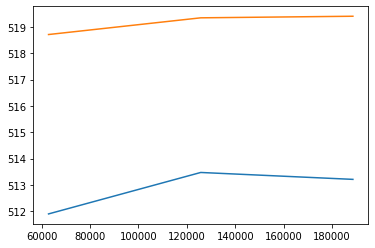

Train:513.17
Test:521.846
Train:513.493
Test:520.403
Train:512.883
Test:521.595
(RolloutWorker pid=47202) 43 200 454.8817165990488
(RolloutWorker pid=47200) 47 200 388.646416386002
(RolloutWorker pid=47198) 63 200 435.86013719695626
(RolloutWorker pid=47201) 49 200 411.12646415346387
(RolloutWorker pid=47205) 6 200 347.4118093328619
(RolloutWorker pid=47204) 19 200 412.85778310441884
(RolloutWorker pid=47879) 8 200 434.397996175622
(RolloutWorker pid=47956) 1 200 390.4017290359022
(RolloutWorker pid=47199) 22 200 518.6534401649814
(RolloutWorker pid=47765) 34 200 392.96632183859145
(RolloutWorker pid=48181) 55 200 459.5169656038247
(RolloutWorker pid=47203) 30 200 454.91163806904973
(RolloutWorker pid=47917) 58 200 432.4077078620997
(RolloutWorker pid=48143) 20 200 388.50658147195946
(RolloutWorker pid=47802) 8 200 436.3922341515173
(RolloutWorker pid=47841) 60 200 427.5585023169273
/home/mbyx3tk2/ray_results/PPO_CropEnv_2022-03-04_16-13-436vum8c1m/checkpoint_000020/checkpoint-20


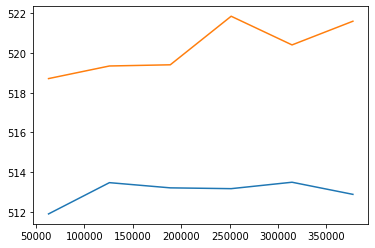

Train:513.077
Test:518.843
Train:513.198
Test:521.309
Train:513.01
Test:515.775
(RolloutWorker pid=47205) 25 300 479.26109223777956
(RolloutWorker pid=47917) 27 300 501.54613307277737
(RolloutWorker pid=47956) 24 300 520.3515756415027
(RolloutWorker pid=48143) 46 300 476.38961893630153
(RolloutWorker pid=47200) 26 300 500.6110255277578
(RolloutWorker pid=47201) 41 300 478.39846246330706
(RolloutWorker pid=47204) 26 300 458.2332752857716
(RolloutWorker pid=47765) 6 300 499.45203668967326
(RolloutWorker pid=48181) 49 300 502.823645462532
(RolloutWorker pid=47802) 41 300 500.12519734579746
(RolloutWorker pid=47198) 30 300 501.92872853893743
(RolloutWorker pid=47203) 70 300 520.7483767009895
(RolloutWorker pid=47199) 53 300 521.2965892093398
(RolloutWorker pid=47879) 17 300 500.4911579968176
(RolloutWorker pid=47202) 4 300 522.2376832052634
(RolloutWorker pid=47841) 27 300 474.44827290438417
/home/mbyx3tk2/ray_results/PPO_CropEnv_2022-03-04_16-13-436vum8c1m/checkpoint_000030/checkpoint-30


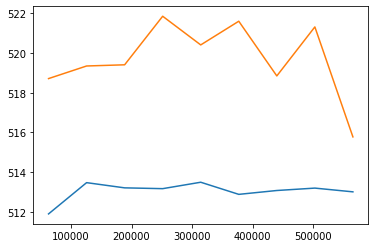

Train:513.935
Test:520.457
Train:511.454
Test:520.137


2022-03-04 16:41:34,334	WARNING metrics.py:109 -- WARNING: collected no metrics in 180 seconds


KeyboardInterrupt: 

In [38]:
proftrain=[]
proftest=[]
timesteps=[]

for i in range(1,500001):
    result = agent.train()

    ts = result['timesteps_total']

    #print(pretty_print(result))

    if i%10==0:
        checkpoint_path = agent.save()
        print(checkpoint_path)
        # trained_config = config.copy()
        # test_agent =ppo PPOTrainer(trained_config, CropEnv)
        # test_agent.restore(checkpoint_path)
        result_df = pd.DataFrame([timesteps,proftrain,proftest]).T
        result_df.to_csv('ppo70_cloned.csv')
        plt.plot(timesteps,proftrain)
        plt.plot(timesteps,proftest)
        plt.show()
        if timesteps[-1]>=40_000_000:
            break

    if i%3==0:

        test_env_config1=copy.deepcopy(test_env_config)
        test_env_config1['evaluation_run']=True
        train_rew, test_rew = evaluate_agent(agent,CropEnv,test_env_config1)
        
        proftrain.append(train_rew)
        proftest.append(test_rew)
        timesteps.append(ts)

        print(f'Train:{round(train_rew,3)}')
        print(f'Test:{round(test_rew,3)}')
